# PyGeM
## Tutorial 6: Deformation of the computational mesh through an RBF interpolator

In this tutorial we're going to show the procedure to propagate a given object deformation to the computational grid built around such a object. In this way, any deformation mapping we can apply to the object to morph is replicated to all discretized space around it, avoiding the expensive re-meshing phase. In this tutorial we just show the needed steps to achieve such parametric mesh exploiting the **PyGeM** package, presenting a very simple test-case, but for a practical real-world usecase we refer to
-  Hull Shape Design Optimization with Parameter Space and Model Reductions, and Self-Learning Mesh Morphing
by Nicola Demo, Marco Tezzele, Andrea Mola and Gianluigi Rozza. J. Mar. Sci. Eng. 2021, 9(2), 185; https://doi.org/10.3390/jmse9020185.


### The numerical settings
The methodology that follows is very general and can be extended to many different scenario, since it basically requires only the coordinates of the nodes of the object geometry and of the (undeformed) initial mesh. For sake of simplicity, here we present the deformation of an [OpenFOAM](https://openfoam.org/) grid for simulating a 2D Navier-Stokes flow around a cylinder. We assume that this cilinder is the object to deform.
Even if the entire procedure is employable also when the deformation mapping applied to the initial object is unknown (we see in few lines that the required input is just the displacement of the initial object after the deformation), here we apply the *free-form deformation* method to the undeformed cylinder in order to parametrize its geometry.

First of all, we import all the libraries which we're going to use:
- `numpy` and `matplotlib` for the generic scientific environment;
- `Smithers` for dealing with the OpenFOAM mesh;
- `PyGeM` for the object and mesh deformation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# mesh parsing
from smithers.io.openfoam.openfoamhandler import OpenFoamHandler
# interpolator
from scipy.interpolate import Rbf
# deformation
from pygem import FFD, RBF

Then we define the auxiliary function `scatter3d` which we're going to use often to plot several objects as lists of 3D points. You do not need to understand the exact details of this function since we are going to use it only to show the results:

In [2]:
def scatter3d(arr, figsize=(8,8), s=10, draw=True, ax=None, alpha=1, labels=None):
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(projection='3d')
        
    for idx,a in enumerate(arr):
        if labels is not None:
            ax.scatter(*a.T, s=s, alpha=alpha, label=labels[idx])
        else:
            ax.scatter(*a.T, s=s, alpha=alpha)
        
    if draw:
        if labels is not None:
            plt.legend()
        plt.show()
    else:
        return ax

## 1) Extraction of the mesh points

In few words, the procedure uses the the nodes coordinates of the deformed object in order to fit the RBF interpolator which will propagate such morphing to the computational grid.
The first step is then the extraction of such points: we specify that, for avoiding that also the mesh boundaries are deformed, we need to force a *zero* displacement there. We can easily obtain that by passing these bondaries as the RBF control points.

As we mentioned before, in this tutorial we use the library `Smithers` to load the OpenFOAM mesh from the folder `openfoam_mesh` which serves as example. First of all, we use the method `read()` from the class `OpenFoamHandler` to load the data. This method returns a dictionary which contains all the informations available about the mesh, included the list of points (`mesh['points']`).

In [3]:
# we load the OpenFOAM mesh
openfoam_handler = OpenFoamHandler()
mesh = openfoam_handler.read('openfoam_mesh')

Moreover, the object returned by `read()` contains a list of points for each *boundary*, represented by a list of indexes which refers to `mesh['points']`. We can use these lists to obtain the coordinates of the points which compose the cylinder (which we call *obstacle*) and walls.

In [11]:
wall_keys = [b'inlet', b'outlet1', b'outlet2', b'defaultFaces']
walls = mesh['points'][np.concatenate([mesh['boundary'][k]['points'] for k in wall_keys])]

#obstacle = mesh['points'][mesh['boundary'][b'obstacle']['points']]

At this point we can plot the obstacle and the walls using the auxiliary function `scatter3d`:

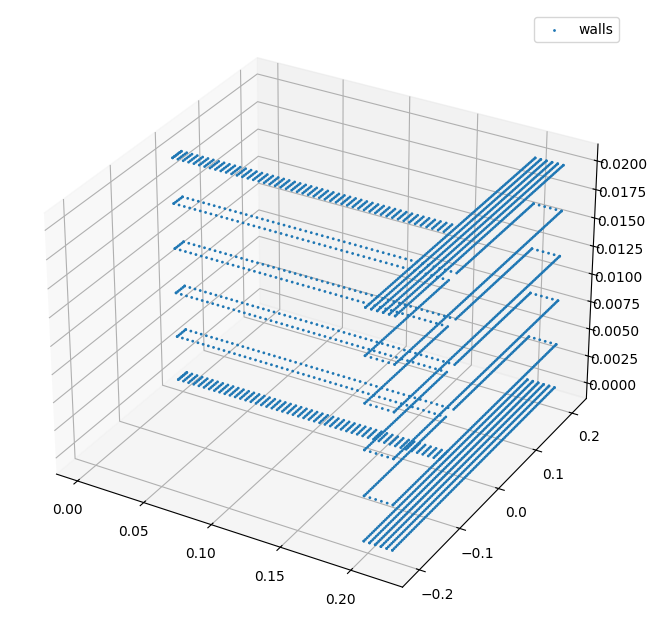

In [12]:
#scatter3d([obstacle, walls], s=1, labels=['obstacle', 'walls'])
scatter3d([walls], s=1, labels=['walls'])

As you can see our geometry is made of two faces, one at `z=0.5` and the other at `z=-0.5`.

## 2) Object Deformation

Here we need to apply a generic deformation on the initial object (the cylinder here). In case this deformation is already computed, you can skip this section, having the forethought of storing the nodes coordinates of the undeformed and deformed object.

We use the `FFD` deformation from [PyGeM](https://github.com/mathLab/PyGeM) (for a reference check [this tutorial](http://mathlab.github.io/PyGeM/tutorial-1-ffd.html)) to deform the original object (the upper and lower faces of a cylinder). We create the new `FFD` object and set its attributes in order to create a simple deformation

In [13]:
ffd = FFD([2, 2, 2])

ffd.box_origin = np.array([0.1, 0, 0.01])
ffd.box_length = np.array([0.4, 0.4, 0.02])

ffd.array_mu_x[1, 1, 0] = 0.3
ffd.array_mu_y[1, 1, 0] = 0.3

ffd.array_mu_x[1, 1, 1] = 0.3
ffd.array_mu_y[1, 1, 1] = 0.3

We then operate the deformation and plot the result, against the old version of the obstacle.

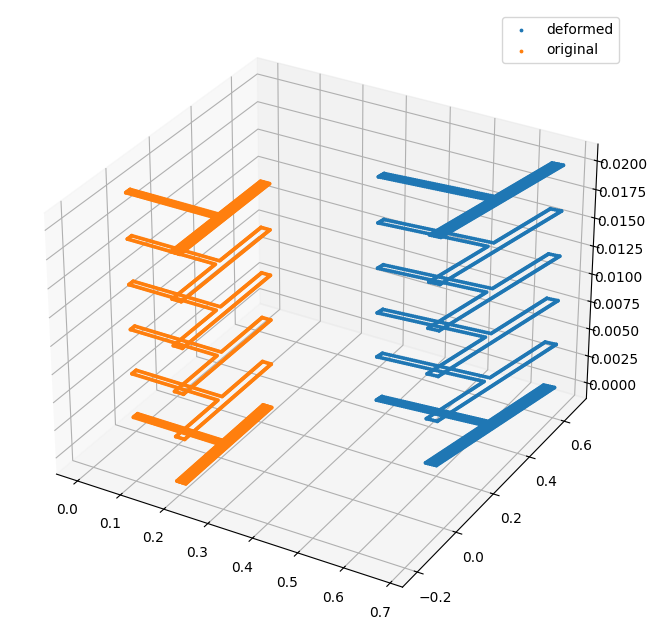

In [15]:
new_walls = ffd(walls)
scatter3d([new_walls, walls], s=3, labels=['deformed', 'original'])

## 3) Propagation of the deformation to the computational mesh

We have now to deform the grid according to the object deformation. Once we have the coordinates of the undeformed and deformed object (and, we remark, also the boundaries that have to been fixed), we can just use them to fed an RBF interpolator.

We employ the `RBF` class from **PyGeM**.
For a reference on the parameters available when using the class `RBF` from **PyGeM**, please check the [documentation](http://mathlab.github.io/PyGeM/rbf.html). We keep the default values for all the parameters except `radius`, for which we set `radius=5`. This parameter is a scaling coefficient which affects the shape of the radial basis function used for the interpolation.
A practical note: long story short, `RBF` solves a linear system to fit the input data. However the matrix representing our system may result singular if we pass more times the same point(s). To avoid this issue, we just extract the `unique` points, as show in the next cell.

In [8]:
undeformed_points = np.vstack([walls, obstacle])
deformed_points   = np.vstack([walls, new_obstacle])
    
undeformed_points, uindexes = np.unique(undeformed_points, return_index=True, axis=0)
deformed_points   = deformed_points[uindexes]
    
rbf = RBF(original_control_points=undeformed_points, deformed_control_points=deformed_points, radius=5)

As visual proof, we plot the original and deformed control points we pass to `RBF` constructor!

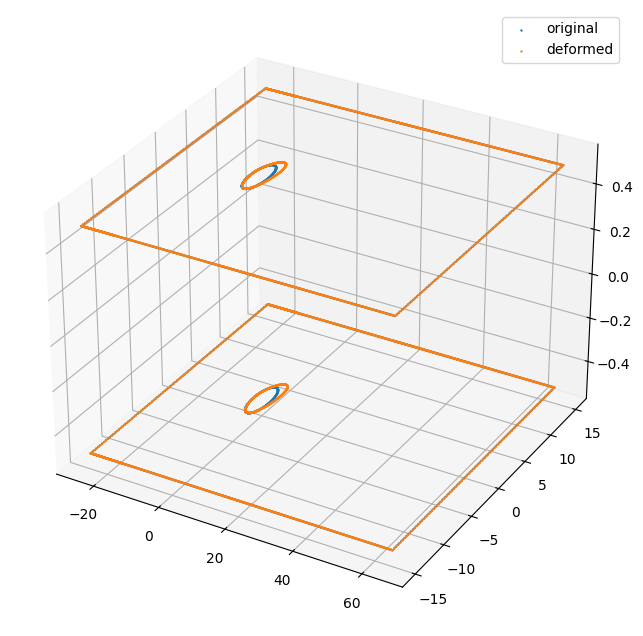

In [9]:
scatter3d([rbf.original_control_points, rbf.deformed_control_points], s=0.5, labels=['original', 'deformed'])

At this point we can use the ingredients we prepared in the last sections to obtain the parametric mesh.

We can use the `RBF.__call__()` method to determine the new position of the points which compose the mesh. This is a resource-intensive computation and may slow down the device on which you're running this notebook.

In [10]:
new_mesh_points = rbf(mesh['points'])

And basically that's all! The array `new_mesh_points` contains the new coordinates of the mesh points, and give us the possibility to store it in a new file or exploit them for some computation.

The last thing we show here is the visualization of the deformed mesh. In order to plot the results we prefer a 2D scatter plot of the upper part of the mesh (`z=0.5`). Therefore we define the auxiliary function `upper_layer` which extracts the points at `z=0.5` from the given list of points.

In [11]:
def upper_layer(*arrs):
    points = arrs[0]
    idxes = points[:,2] > 0
    
    if len(arrs) > 1:
        return (arr[idxes] for arr in arrs)
    else:
        return points[idxes]

We can now plot the interpolated mesh, with the *deformed* and *original* obstacle.

In [12]:
plt.figure(figsize=(20,8), dpi=300)
plt.scatter(*upper_layer(new_mesh_points)[:,:2].T, s=0.2, label='Interpolated mesh')
plt.scatter(*upper_layer(obstacle)[:,:2].T, s=1, color='g', label='Original obstacle')
plt.scatter(*upper_layer(new_obstacle)[:,:2].T, s=1, color='r', label='Deformed obstacle')

plt.margins(x=0, y=0)
plt.legend(prop={"size":15}, markerscale=15)
plt.title('New mesh')

plt.show()
plt.figure(figsize=(20,8), dpi=300)
plt.scatter(*upper_layer(new_mesh_points)[:,:2].T, s=0.2, label='Interpolated mesh')
plt.scatter(*upper_layer(obstacle)[:,:2].T, s=1, color='g', label='Original obstacle')
plt.scatter(*upper_layer(new_obstacle)[:,:2].T, s=1, color='r', label='Deformed obstacle')
plt.axis([-3.5, 4.5, -4, 4])
plt.margins(x=0, y=0)
plt.legend(prop={"size":15}, markerscale=15)
plt.title('New mesh [zoom]')

plt.show()

NameError: name 'new_mesh_points' is not defined

<Figure size 6000x2400 with 0 Axes>